In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import math

In [14]:
class Figure:
    def __init__(self):
        super(Figure, self).__init__()
        self.points = []
    
    def draw(self, pivotPoints=[]):
        x = np.asarray([x for (x, _) in self.points])
        y = np.asarray([y for (_, y) in self.points])
        plt.scatter(x, y, [2 for i in x])
        for (px, py) in pivotPoints:
            plt.scatter(px, py, c = 'green')
        plt.show()

class Ellipse(Figure):
    def __init__(self, a, b, pointCount):
        super(Ellipse, self).__init__()
        for x in np.linspace(-10, 10, num=pointCount):
            self.points.append((x, b / a * (a ** 2 - x ** 2) ** 0.5))
        
class Circle(Ellipse):
    def __init__(self, r, pointCount):
        super(Circle, self).__init__(r, r, pointCount)
        
class SuperEllipseHalfed(Figure):
    def __init__(self, aOne, bOne, nOne, aTwo, bTwo, nTwo, pointCount):
        super(SuperEllipseHalfed, self).__init__()
        for theta in np.linspace(0, 2*math.pi, num=pointCount, endpoint=False):
            cosTheta = math.cos(theta)
            sinTheta = math.sin(theta)
            if theta < math.pi:
                a = aOne
                b = bOne
                n = nOne
            else:
                a = aTwo
                b = bTwo
                n = nTwo
            x = a*pow(abs(cosTheta), 2/n)* np.sign(cosTheta)
            y = b*pow(abs(sinTheta), 2/n)* np.sign(sinTheta)   
            self.points.append((x, y))
    
class Oval(Figure):
    def __init__(self, e1, e2, center, pointCount):
        super(Oval, self).__init__()
        points = []
        points += list(filter(
            lambda p: (
                p[0] < 0 and
                p[1] > 0
            ), e2.points
        ))
        points += list(filter(
            lambda p: (
                p[1] >= 0 and
                p[0] >= 0
            ), e1.points
        ))
        points += [(2 * center[0] - p[0], 2 * center[1] - p[1]) for p in points]
        y_pos = list(filter(lambda p: p[1] >= 0, points))
        y_neg = list(filter(lambda p: p[1] < 0, points))
        y_pos = sorted(y_pos, key=lambda p: math.acos(p[0]/((p[0]**2 + p[1]**2) ** 0.5)))
        y_neg = sorted(y_neg, key=lambda p: math.acos(p[0]/((p[0]**2 + p[1]**2) ** 0.5)), reverse=True)
#         y_pos, y_neg = self.filter_nearest(y_pos, self.step), self.filter_nearest(y_neg, self.step)
        self.points = y_pos + y_neg


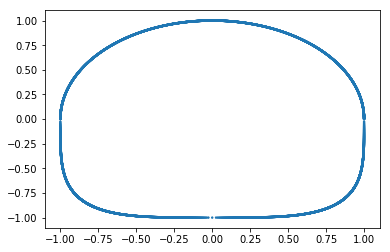

In [15]:
superEllipseHalfed = SuperEllipseHalfed(1, 1, 2, 1, 1, 4, 10000)
superEllipseHalfed.draw()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


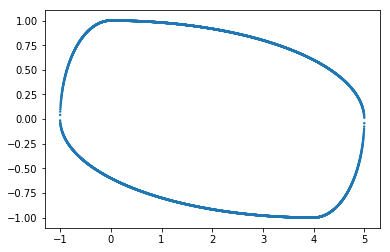

In [16]:
e1 = Ellipse(5, 1, 10000)
e2 = Circle(1, 10000)
center = (2, 0)

oval = Oval(e1, e2, center, 10000)
oval.draw()

In [17]:
class PivotPointsFinder:
    def __init__(self, points, startingCenterIndex, count):
        self.points = points
        self.startingCenterIndex = startingCenterIndex
        self.count = count
        
    def getEnsemble(self, centerIndex):
        radius = int((self.count - 1)/2)
        pointsCount = len(self.points)
        if centerIndex - radius < 0:
            return self.points[centerIndex - radius:] + self.points[:centerIndex + radius + 1]
        elif centerIndex + radius >= pointsCount:
            return self.points[centerIndex - radius:] + self.points[:centerIndex + radius + 1 - pointsCount]
        else:
            return self.points[centerIndex - radius:centerIndex + radius + 1]
        
    def getEnsembleCoefs(self, centerIndex):
        ensemble = self.getEnsemble(centerIndex)
        coefs = np.array([np.array([pow(x, 2), pow(y, 2), x*y, x, y]) for (x, y) in ensemble])
        values = np.repeat(-1, self.count)
        return np.linalg.solve(coefs, values)
    
    def checkIfPivotPoint(self, pivotPoints, initialCoefs, isGoingRight):
        currentCoefs = self.getEnsembleCoefs(centerIndex)
        for initialCoef, currentCoef in zip(initialCoefs, currentCoefs):
            if abs(initialCoef-currentCoef) > threshold:
                print(currentCoefs)
                print("------")
                pivotPoints.append(self.points[centerIndex])
    
    def findPivotPoints(self, step = 10, threshold = 0.01):
        pivotPoints = []
        isFound = False
        initialCoefs = self.getEnsembleCoefs(self.startingCenterIndex)
        print("0")
        print(initialCoefs)
        print("------")
        # center -> right
        if self.startingCenterIndex < len(self.points) - 1:
            for centerIndex in np.arange(self.startingCenterIndex+1, len(self.points), step):
                currentCoefs = self.getEnsembleCoefs(centerIndex)
                for initialCoef, currentCoef in zip(initialCoefs, currentCoefs):
                    if abs(initialCoef-currentCoef) > threshold:
                        print("1")
                        print(currentCoefs)
                        print("------")
                        isFound = True
                        pivotPoints.append(self.points[centerIndex])
                        break
                if isFound:
                    initialCoefs = currentCoef
                    continue
        
        for centerIndex in np.arange(0, self.startingCenterIndex, step):
            currentCoefs = self.getEnsembleCoefs(centerIndex)
            for initialCoef, currentCoef in zip(initialCoefs, currentCoefs):
                if abs(initialCoef-currentCoef) > threshold:
                    print("2")
                    print(currentCoefs)
                    print("------")
                    isFound = True
                    pivotPoints.append(self.points[centerIndex])
                    break
            if isFound:
                initialCoefs = currentCoef
                continue
        
        isFound = False
        # left <- center
        if self.startingCenterIndex > 0:
            for centerIndex in np.arange(self.startingCenterIndex-1, -1, -step):
                currentCoefs = self.getEnsembleCoefs(centerIndex)
                for initialCoef, currentCoef in zip(initialCoefs, currentCoefs):
                    if abs(initialCoef-currentCoef) > threshold:
                        print("3")
                        print(currentCoefs)
                        print("------")
                        isFound = True
                        if pivotPoints[-1] != self.points[centerIndex]: #check we haven't reached the same point as in center -> right
                            pivotPoints.append(self.points[centerIndex])
                        break
                if isFound:
                    initialCoefs = currentCoef
                    continue
            
        for centerIndex in np.arange(len(self.points), self.startingCenterIndex, -step):
            currentCoefs = self.getEnsembleCoefs(centerIndex)
            for initialCoef, currentCoef in zip(initialCoefs, currentCoefs):
                if abs(initialCoef-currentCoef) > threshold:
                    print("4")
                    print(currentCoefs)
                    print("------")
                    isFound = True
                    if pivotPoints[-1] != self.points[centerIndex]:
                        pivotPoints.append(self.points[centerIndex])
                    break
            if isFound:
                initialCoefs = currentCoef
                continue
        return pivotPoints        

In [18]:
pivotPointsFinder = PivotPointsFinder(superEllipseHalfed.points, 3700, 5)
pivotPoints = pivotPointsFinder.findPivotPoints(step = 1)
print(pivotPoints)

0
[-1.00000007e+00 -9.99999926e-01  9.38350206e-09 -1.08971057e-07
 -1.01902037e-07]
------
1
[ 9.99997785e-01 -2.25981230e-08 -1.88447861e-03  1.99999779e+00
 -1.88447898e-03]
------


TypeError: zip argument #1 must support iteration

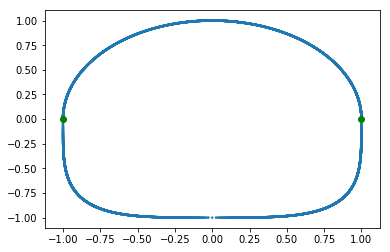

In [36]:
superEllipseHalfed.draw(pivotPoints)

0
[-1.11263245e-01 -2.78144553e+00 -7.46834895e-04  8.89030077e-01
 -2.20028937e-03]
------
1
[-1.11072600e-01 -2.77684772e+00  1.89016170e-04  8.88852857e-01
  5.57940466e-04]
------
3
[-1.10933554e-01 -2.77350284e+00  8.71765463e-04  8.88725145e-01
  2.56454900e-03]
------
[(0.4026402640264024, -0.6945215023308053), (0.39863986398639817, -0.6936917231950255)]


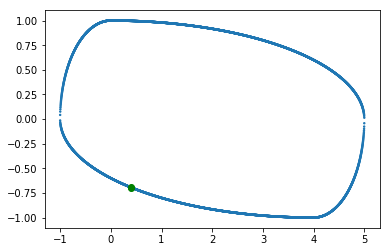

In [11]:
pivotPointsFinder = PivotPointsFinder(oval.points, 3700, 5)
pivotPoints = pivotPointsFinder.findPivotPoints(step = 1, threshold = 0.0001)
print(pivotPoints)
oval.draw(pivotPoints)

In [ ]:
class StandardCoordinateSystemTransformer:
    def transform(points, cPoints):
        z = c[6]*x+c[7]*y+1
        return list(map(lambda (x, y): ((c[0]*x+c[1]*y+c[2])/z,(c[3]*x+c[4]*y+c[5])/z), points))

In [ ]:
import sys
# Proektivno-invariantnoe otobrazhenie figur 
class WurfMapper:
    def segmentLength(p1, p2):
        return pow(pow((p1[0] - p2[0]), 2) + pow((p1[1] - p2[1]), 2), 1/2)
    
    def wurf(p1, p2, p3, p4):
        sortedList = sorted([p1, p2, p3, p4], key=lambda p: segmentLength(p1, p))
        p2 = sortedList[1]
        p3 = sortedList[2]
        p4 = sortedList[3]
        
        a = segmentLength(p1, p2)
        b = segmentLength(p3, p2)
        c = segmentLength(p4, p3)
        
        return a*c/(b(a+b+c))
    
    # Point of intersection between two lines represented in the form of kx + b
    def intersectionPoint(k1, b1, k2, b2):
        return (-(b1 - b2) / (k1 - k2), k1 * x + b1) if k1 != k2 else None
    
    def getP(points, pivotPoint1Index, pivotPoint2Index):
        k1, b1 = tangent(points[pivotPoint1Index-2], points[pivotPoint1Index-1], points[pivotPoint1Index], points[(pivotPoint1Index+1)%len(points)], points[(pivotPoint1Index+1)%len(points)])
        k2, b2 = tangent(points[pivotPoint2Index-2], points[pivotPoint1Index-1], points[pivotPoint1Index], points[(pivotPoint1Index+1)%len(points)], points[(pivotPoint1Index+1)%len(points)])
        return intersectionPoint(k1, b1, k2, b2)
    
    def getPj(points, pivotPoint1Index, pivotPoint2Index, P, Pi):
        k1, b1 = getLineByPoints(points[pivotPoint1Index], points[pivotPoint2Index])
        k2, b2 = getLineByPoints(P, Pi)
        return intersectionPoint(k1, b1, k2, b2)
    
    # Find closest point to the line [P, P_i] among points forming the oval (find P_k)
    def getPk(points, k, b, pivotPoint1Index, pivotPoint2Index):
        minDelta = Integer.MAX_VALUE
        kOpt = 0
        numPoints = len(points)

        k1 = pivotPoint2Index
        while k1 != pivotPoint1Index:
            delta = geometry.line2pointDist((crossPoint, points[k]), points[k1])
            if delta <= minDelta:
                minDelta = delta
                kOpt = k1
            elif minDelta < 10:
                return kOpt
            else:
                return None
            k1 = (k1 + 1) % numPoints

        if minDelta > 10:
            return None
        else:
            return kOpt
    
    def getTi(points, i, pivotPoint1Index, pivotPoint2Index):
        k1, b1 = tangent(points[i-2], points[i-1], points[i], points[i+1], points[i+2])
        k2, b2 = getLineByPoints(points[pivotPoint1Index], points[pivotPoint2Index])
        return intersectionPoint(k1, b1, k2, b2)
    
    def buildWf1Wf2(points, pivotPoint1Index, pivotPoint2Index):
        P = getP(points, pivotPoint1Index, pivotPoint2Index)
        A = points[pivotPoint1Index]
        B = points[pivotPoint2Index]
        wf1s = []
        wf2s = []
        for i in [pivotPoint1Index+1:pivotPoint2Index]:
            Pi = points[i]
            Pj = getPj(points, pivotPoint1Index, pivotPoint2Index, P, Pi)
            k, b = getLineByPoints(P, Pi)
            Pk = getPk(points, k, b, pivotPoint1Index, pivotPoint2Index)
            wf1s.append(wurf(P, Pi, Pj, Pk))
            Ti = getTi(points, i, pivotPoint1Index, pivotPoint2Index)
            wf2s.append(wurf(Ti, A, Pj, B))
        plotWf1Wf2(wf1s, wf2s)
            
    def plotWf1Wf2(wf1s, wf2s):
        plt.plot(wf1s, wf2s, 'ro')
        plt.show()
        
    # Returns k, b of a line which p1, p2 lie on
    def getLineByPoints(p1, p2):
        x1, y1 = p1
        x2, y2 = p2
        k = (y2-y1)/(x2-x1)
        b = y2 - k*x2
        return (k, b)
    
    # Distance between line represented by two points and p
    def line2pointDist(l, p):
        p1, p2 = l
        x1, y1 = p1
        x2, y2 = p2
        x, y = p
        A = y2 - y1
        B = x2 - x1
        C = x2*y1 - y2*x1
        d = abs(A * x - B * y + C * 1.0) / (A ** 2 + B ** 2) ** 0.5
        return d
        
    # df = (y2-y1)/(x2-x1)
    def derivative(a1, a2, c1, c2):
        a1x, a1y = a1
        a2x, a2y = a2
        c1x, c1y = c1
        c2x, c2y = c2
        return (
            (a1y + a2y - c1y - c2y) /
            (a1x + a2x - c1x - c2x)
        )
    
    # y = f ’(x0) · (x − x0) + f (x0)
    # Returns (k, b)
    def tangent(a1, a2, current, c1, c2):
        if a1[0] + a2[0] - c1[0] - c2[0] == 0:
            return None
        return (derivative(a1, a2, c1, c2), current[1] - k * current[0])
    
    